# 1. Read Data

In [64]:
import pandas as pd
import numpy as np
import random
import math
# read data
df = pd.read_excel(open('results/tag0_02-14-1_dataByMinute.xlsx','rb'))
my_date = '2022-02-14'
points = []
for i in range(1, len(df['hour'])):
    point = [df['x值'][i],df['y值'][i]]
    points.append(point)

points_array = np.array(points)

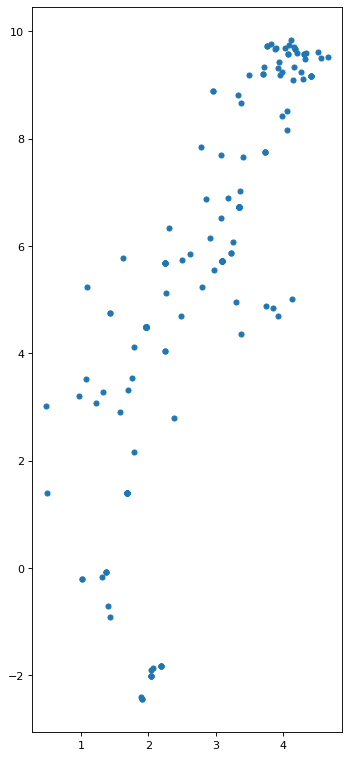

In [50]:
import sklearn
from sklearn.datasets import make_blobs
from matplotlib import pyplot as plt

plt.figure(figsize=(5, 12), dpi=80)
plt.scatter(points_array[:,0],points_array[:,1],s=20)

# 2. Grid Creator

In [51]:
xs = []
ys = []
ts = []
for i in range(1, len(df['hour'])):
    ts.append(df['time'][i])
    xs.append(df['x值'][i])
    ys.append(df['y值'][i])
c={ "time":ts,"x":xs,'y':ys} 
data= pd.DataFrame(c)
max_x = 6
min_x = -1
max_y = 11
min_y = -3
column_num = 28
row_num = 56

In [52]:
def generalID(x,y,column_num,row_num):
    # 若在范围外的点，返回-1
    if x <= min_x or x >= max_x or y <= min_y or y >= max_y:
        return -1
    # 把x范围根据列数等分切割
    column = (max_x - min_x)/column_num
    # 把y范围根据行数数等分切割
    row = (max_y - min_y)/row_num
    # 二维矩阵坐标索引转换为一维ID，即： （列坐标区域（向下取整）+ 1） + （行坐标区域 * 列数）
    return int((x-min_x)//column)+ 1 + int((y-min_y)//row) * column_num
data['label'] = data.apply(lambda x: generalID(x['x'], x['y'],column_num,row_num), axis = 1)

In [53]:
groups = data['label'].value_counts()
# groups = data.groupby('label') 
# groups.size() # count the number of each grid
print(groups)
# re-organize the grid
grids = np.zeros([row_num,column_num])
for i in groups.index:
    r = (i-1)//column_num  # e.g. (6 - 1) // 12 = 0; (13-1) // 12 = 1; (12-1) // 12 = 0
    c = i - column_num * r - 1 # e.g. 6 - 0 * 12 - 1= 6; 13 - 1 * 12 -1= 0; 12 - 0 * 12 - 1 = 11
    grids[r,c] = math.sqrt(groups[i])  # Do a sqrt to make the heatmap clearer !!!
print(grids)

824     27
1082    16
969     13
487      9
1421     7
        ..
1253     1
1391     1
1138     1
1394     1
968      1
Name: label, Length: 73, dtype: int64
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


# 3. "heatmap"

In [54]:
!pip install seaborn

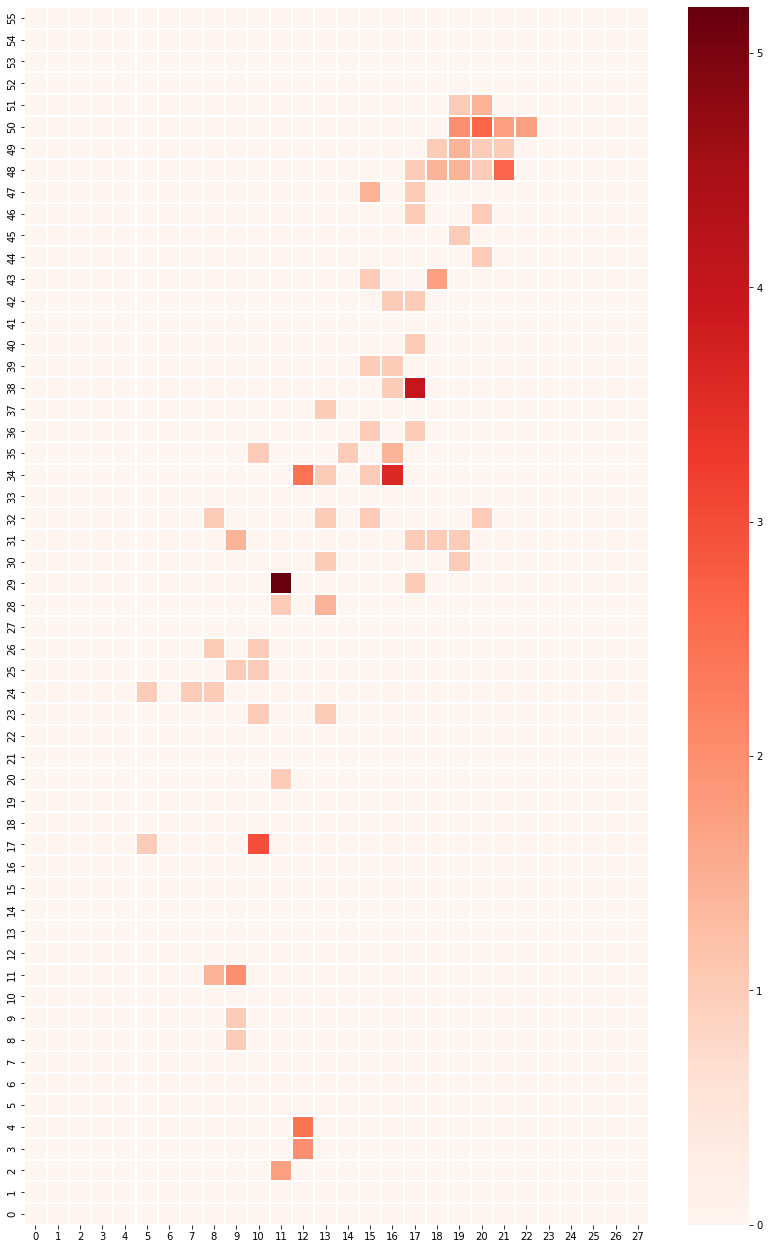

In [55]:
import seaborn as sns

#specify size of heatmap
fig, ax = plt.subplots(figsize=(column_num*0.5,row_num*0.4))
ax = sns.heatmap(grids, cmap='Reds',linewidths=.3)
ax.invert_yaxis()
plt.show()


# 4. slice by time

In [56]:
from collections import defaultdict
# choose zones of labels
dict_zones = defaultdict(list)
def select(label,zone_index,used_labels):
    if (label not in groups.index) or (label in used_labels) or groups[label] <=3 or label <= 0 or label > row_num*column_num :
        return False
    dict_zones[zone_index].append(label)
    used_labels.append(label)
    select(label-column_num,zone_index,used_labels)
    select(label+column_num,zone_index,used_labels)
    if label%column_num != 0:
        select(label+1,zone_index,used_labels)
    if label%column_num != 1:
        select(label-1,zone_index,used_labels)
    return True


In [57]:
zone_index = 1
used_labels = []
for label in groups.index:
    if label in used_labels:
        continue
    else:
        select(label,zone_index,used_labels)
        zone_index += 1
print(dict_zones)

defaultdict(<class 'list'>, {1: [824], 2: [1082], 3: [969], 4: [487], 5: [1421, 1420], 6: [1366], 7: [965], 8: [125, 97], 9: [318]})


In [58]:
import datetime
from datetime import timedelta
# slice by time
def sliceByTime(time_list):
    max_interval = 1
    times_in_zone = []
    epsilon = timedelta(minutes=10)
    temp_count = 1
    start_time = time_list[0]
    end_time = time_list[0]
    for i in range(1,len(time_list)):
        t1 = time_list[i-1]
        t2 = time_list[i]
        time_delta = timedelta(hours=t2.hour,minutes=t2.minute) - timedelta(hours=t1.hour,minutes=t1.minute) 
        if time_delta >= epsilon:
            max_interval = max(temp_count,max_interval)
            temp_count = 1
            end_time = t1
            times_in_zone.append([start_time,end_time])
            start_time = t2
        else:
            temp_count += 1
    max_interval = max(max_interval,temp_count)
    end_time = time_list[-1]
    times_in_zone.append([start_time,end_time])
    return max_interval,times_in_zone

In [59]:
# get the data of corresponding zone
result = {}
details = {}
for zone in dict_zones:
    labels = dict_zones[zone]
    data_zone = data.loc[data['label'].isin(labels)]
    # print(data_zone)
    time_list = data_zone['time'].tolist()
    result[zone],details[zone] = sliceByTime(time_list)

print(result)
print(details)

{1: 27, 2: 16, 3: 13, 4: 9, 5: 6, 6: 5, 7: 6, 8: 9, 9: 4}
{1: [[datetime.time(12, 41), datetime.time(13, 7)]], 2: [[datetime.time(13, 36), datetime.time(13, 51)]], 3: [[datetime.time(13, 8), datetime.time(13, 20)]], 4: [[datetime.time(13, 25), datetime.time(13, 33)]], 5: [[datetime.time(11, 44), datetime.time(11, 48)], [datetime.time(12, 22), datetime.time(12, 28)], [datetime.time(12, 39), datetime.time(12, 40)]], 6: [[datetime.time(11, 24), datetime.time(11, 28)], [datetime.time(11, 53), datetime.time(11, 53)], [datetime.time(12, 38), datetime.time(12, 38)]], 7: [[datetime.time(11, 4), datetime.time(11, 9)]], 8: [[datetime.time(11, 55), datetime.time(12, 3)], [datetime.time(12, 15), datetime.time(12, 15)]], 9: [[datetime.time(12, 6), datetime.time(12, 16)]]}


# 5. heatmap by time

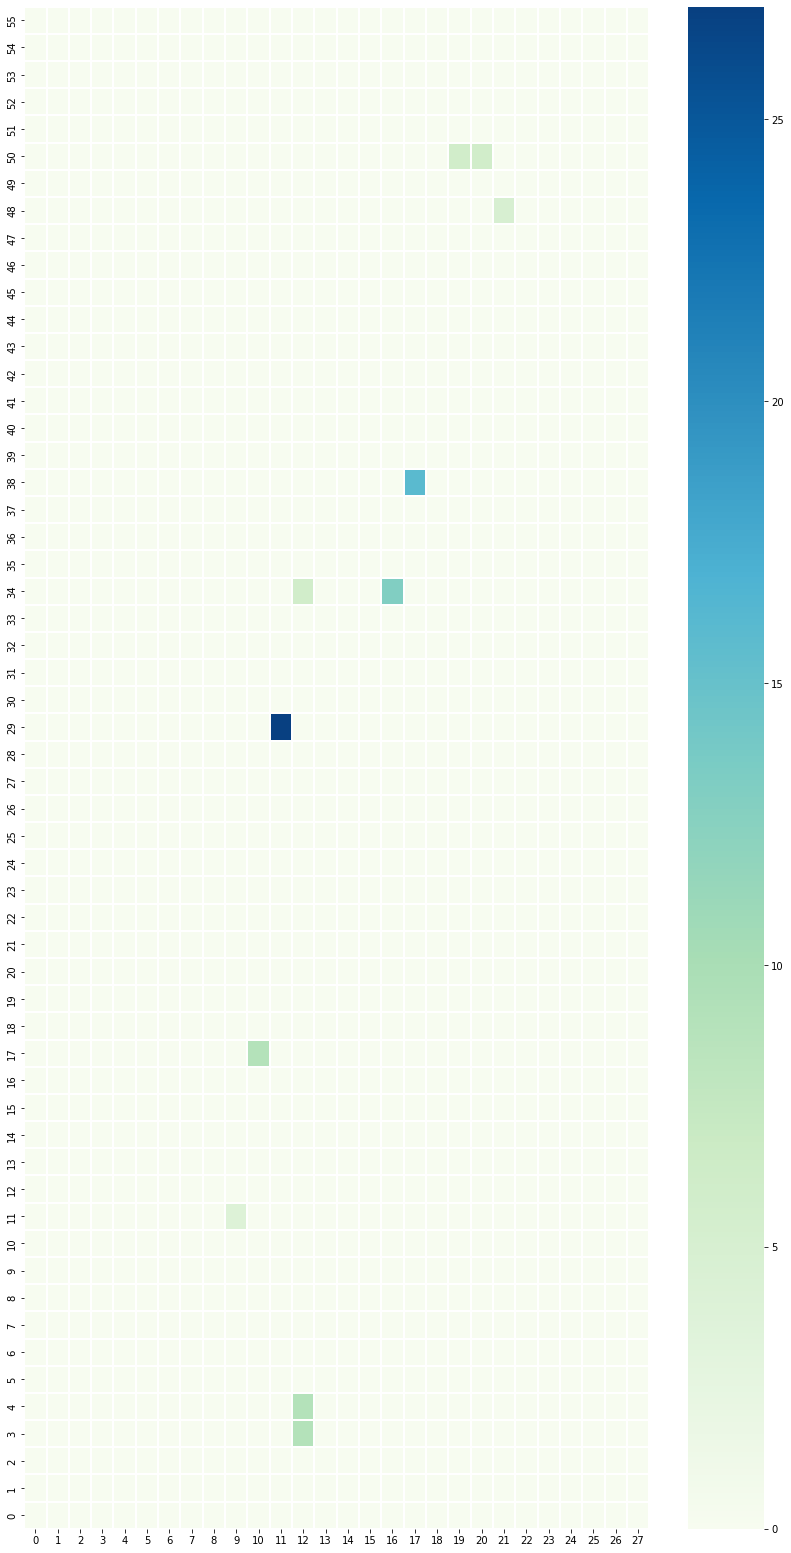

In [60]:
# re-organize the grid
new_grids = np.zeros([row_num,column_num])
for zone in result:
    for label in dict_zones[zone]:
        r = (label-1)//column_num  # e.g. (6 - 1) // 12 = 0; (13-1) // 12 = 1; (12-1) // 12 = 0
        c = label - column_num * r - 1 # e.g. 6 - 0 * 12 - 1= 6; 13 - 1 * 12 -1= 0; 12 - 0 * 12 - 1 = 11
        new_grids[r,c] = result[zone]  # Do a sqrt to make the map clearer !!!
#specify size of heatmap
fig, ax = plt.subplots(figsize=(column_num*0.5,row_num*0.5))
ax = sns.heatmap(new_grids, cmap='GnBu',linewidths=.3)
ax.invert_yaxis()
plt.show()

# 6. Time line

In [65]:
import datetime as dt
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.collections import PolyCollection

timeline = []
for zone in details:
    for t in details[zone]:
        # datetime.time to datetime.datetime
        date = str(datetime.datetime.strptime(my_date, '%Y-%m-%d').date())
        t0 = pd.to_datetime(date + " " + t[0].strftime("%H:%M:%S"))
        t1 = pd.to_datetime(date + " " + t[1].strftime("%H:%M:%S"))
        timeline.append((t0, t1, zone))
print(timeline)


[(Timestamp('2022-02-14 12:41:00'), Timestamp('2022-02-14 13:07:00'), 1), (Timestamp('2022-02-14 13:36:00'), Timestamp('2022-02-14 13:51:00'), 2), (Timestamp('2022-02-14 13:08:00'), Timestamp('2022-02-14 13:20:00'), 3), (Timestamp('2022-02-14 13:25:00'), Timestamp('2022-02-14 13:33:00'), 4), (Timestamp('2022-02-14 11:44:00'), Timestamp('2022-02-14 11:48:00'), 5), (Timestamp('2022-02-14 12:22:00'), Timestamp('2022-02-14 12:28:00'), 5), (Timestamp('2022-02-14 12:39:00'), Timestamp('2022-02-14 12:40:00'), 5), (Timestamp('2022-02-14 11:24:00'), Timestamp('2022-02-14 11:28:00'), 6), (Timestamp('2022-02-14 11:53:00'), Timestamp('2022-02-14 11:53:00'), 6), (Timestamp('2022-02-14 12:38:00'), Timestamp('2022-02-14 12:38:00'), 6), (Timestamp('2022-02-14 11:04:00'), Timestamp('2022-02-14 11:09:00'), 7), (Timestamp('2022-02-14 11:55:00'), Timestamp('2022-02-14 12:03:00'), 8), (Timestamp('2022-02-14 12:15:00'), Timestamp('2022-02-14 12:15:00'), 8), (Timestamp('2022-02-14 12:06:00'), Timestamp('2022

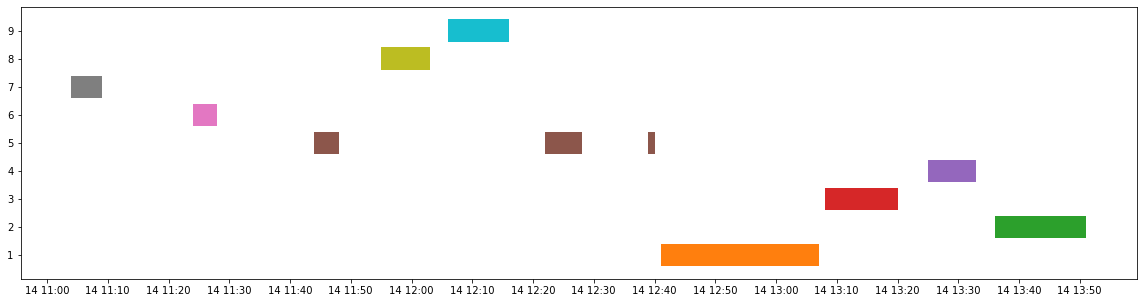

In [85]:
colormapping = {}
for zone in details:
    colormapping[zone] = "C"+str(zone)
verts = []
colors = []
for d in timeline:
    v =  [(mdates.date2num(d[0]), d[2]-.4),
          (mdates.date2num(d[0]), d[2]+.4),
          (mdates.date2num(d[1]), d[2]+.4),
          (mdates.date2num(d[1]), d[2]-.4),
          (mdates.date2num(d[0]), d[2]-.4)]
    verts.append(v)
    colors.append(colormapping[d[2]])
bars = PolyCollection(verts, facecolors=colors)
fig, ax = plt.subplots(figsize=(20,5))
ax.add_collection(bars)
ax.autoscale()
loc = mdates.MinuteLocator(byminute=[0,10,20,30,40,50])
ax.xaxis.set_major_locator(loc)
ax.xaxis.set_major_formatter(mdates.AutoDateFormatter(loc))
ax.set_yticks(list(details.keys()))
ax.set_yticklabels(list(details.keys()))
plt.show()